In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as pl
import re
from sklearn.metrics import classification_report
import bs4
from collections import defaultdict

WORKING_DIR='.'
DEVICE = 'cuda'

In [68]:
dataset_educ = pd.read_json(f'{WORKING_DIR}/Dataset_educ_1.1.json', orient = 'index')
dataset_div = pd.read_json(f'{WORKING_DIR}/Dataset_div2_final.json', orient = 'index')
dataset_unlabelled = pd.read_json(f'{WORKING_DIR}/Dataset_unlabelled.json', orient = 'index')

In [69]:
rounds_educ = set([r.split('?')[0] for r in list(dataset_educ.index)])
rounds_div = set([r.split('?')[0] for r in list(dataset_div.index)])
rounds_unlabelled = set([r.split('?')[0] for r in list(dataset_unlabelled.index)]).difference(rounds_educ, rounds_div)

print(f"Number blogs educational:{len(rounds_educ)}")
print(f"Number blogs div:{len(rounds_div)}")
print(f"Number blogs unlabelled:{len(rounds_unlabelled)}")

Number blogs educational:16
Number blogs div:3
Number blogs unlabelled:1131


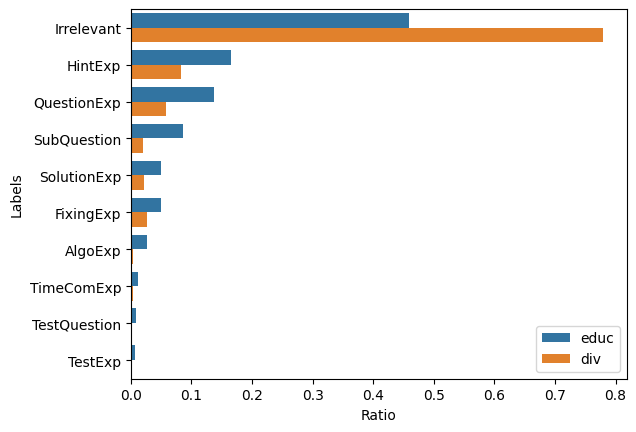

In [70]:
import matplotlib.pyplot as plt
dataset_educ_labels_counts = dataset_educ.label.value_counts(normalize=True)
dataset_div_labels_counts = dataset_div.label.value_counts(normalize=True)

dataset_educ_labels_counts_df = pd.DataFrame({"Labels":dataset_educ_labels_counts.index, 
                                              "Ratio": dataset_educ_labels_counts.values,
                                              "Type": ['educ']*len(dataset_educ_labels_counts)})

dataset_div_labels_counts_df = pd.DataFrame({"Labels":dataset_div_labels_counts.index, 
                                              "Ratio": dataset_div_labels_counts.values,
                                              "Type": ['div']*len(dataset_div_labels_counts)})



figure = sns.barplot(x = 'Ratio', y = 'Labels', hue= 'Type', data = pd.concat([dataset_educ_labels_counts_df, dataset_div_labels_counts_df], axis = 0), orient = 'h')
plt.legend(loc='lower right')

plt.savefig('statistics/label_distribution.png', bbox_inches='tight')

In [83]:
dataset_unlabelled['round_type'] = "div"
dataset_unlabelled.loc[dataset_unlabelled.round_name.str.lower().str.contains('educational'), 'round_type'] = "educ"

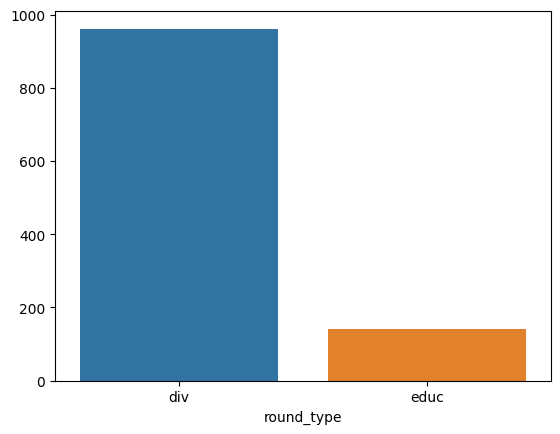

In [120]:
all_rounds_dataset_unlabelled = dataset_unlabelled.groupby('round_id')['round_type'].first()
sns.barplot(y = all_rounds_dataset_unlabelled.value_counts().values, x = all_rounds_dataset_unlabelled.value_counts().keys(), orient='v')

plt.savefig('statistics/div_educ_ratio_contests.png', bbox_inches='tight')

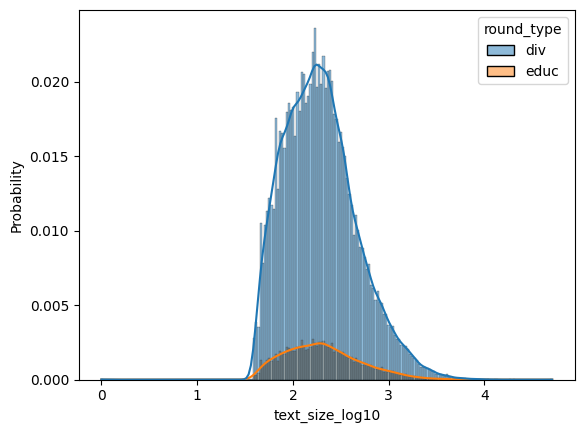

In [122]:
import numpy as np
all_rounds_roundtype_length = dataset_unlabelled.copy()
all_rounds_roundtype_length['text_size_log10'] = np.log10(dataset_unlabelled.text.str.len() + 1)

sns.histplot(x = 'text_size_log10', data = all_rounds_roundtype_length, hue='round_type', stat='probability', kde=True)

plt.savefig('statistics/comments_text_length.png', bbox_inches='tight')

In [129]:
regex_link_ful = re.compile('<a href.*\/contest/.*/submission/.*<\/a>')
code_regex = re.compile('<code>(\s|.)*?<\/code>')
def preprocess_for_transfomers(texts):
  preprocessed_texts = []
  for t in texts:
    t_codes = code_regex.sub(' (code) ', t)
    t_link = regex_link_ful.sub(f' (link to problem) ', t_codes)
    bs = bs4.BeautifulSoup(t_link)
    preprocessed_texts.append(bs.text)
  
  return preprocessed_texts

preprocessed_text = preprocess_for_transfomers(dataset_educ['text'])
dataset_educ["preprocessed_text"] = preprocessed_text

preprocessed_text = preprocess_for_transfomers(dataset_div['text'])
dataset_div["preprocessed_text"] = preprocessed_text

preprocessed_text = preprocess_for_transfomers(dataset_unlabelled['text'])
dataset_unlabelled["preprocessed_text"] = preprocessed_text

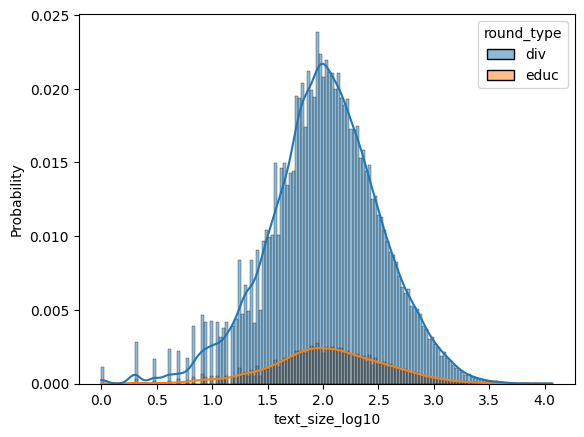

In [130]:
import numpy as np
all_rounds_roundtype_length = dataset_unlabelled.copy()
all_rounds_roundtype_length['text_size_log10'] = np.log10(dataset_unlabelled.preprocessed_text.str.len() + 1)

sns.histplot(x = 'text_size_log10', data = all_rounds_roundtype_length, hue='round_type', stat='probability', kde=True)

plt.savefig('statistics/comments_text_length.png', bbox_inches='tight')